### Build a NN from Scratch
This notebook is based on the Coursera Course: Foundations and Core Concepts of PyTorch.

In [1]:
# Package and Module Imports
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# DATA PREP

# source: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset
df = pd.read_csv('heart.csv')

# Explain the first five rows of the dataset
print(df.head())

# Separate independent / dependent features
X = np.array(df.loc[ :, df.columns != 'output'])     # Select all rows and all columns except 'output'
y = np.array(df['output'])                           # Select all rows and the 'output' column

print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

# Train / Test Split
# test_train_split handles the shuffling of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Scale the data
scaler = StandardScaler()   # Remove the mean and scale to unit variance
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)


   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  
Shape of X: (303, 13), Shape of y: (303,)


In [6]:
class NeuralNetwork:
    def __init__(self, learning_rate, X_train, y_train, X_test, y_test):
        self.learning_rate = learning_rate

        # Initialize random weights with one weight per feature
        self.w = np.random.randn(X_train.shape[1])

        self.b = np.random.randn()
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        self.L_train = []
        self.L_test = []

    def activation(self, x):
        # Sigmoid function
        return 1 / (1 + np.exp(-x))

    def deactivation(self, x):
        # Take the derivative of Sigmoid
        return self.activation(x) * (1 - self.activation(x))
    
    def forward(self, X):
        # Calculate the result layer by layer
        hidden_1 = np.dot(X, self.w) + self.b
        activate_1 = self.activation(hidden_1)
        return activate_1

    def backward(self, X, y_true):
        # Calculate gradients (we're using squared error loss)
        hidden_1 = np.dot(X, self.w) + self.b
        y_pred = self.forward(X)
        
        dL_dpred = 2 * (y_pred - y_true)
        dpred_dhidden1 = self.deactivation(hidden_1)
        dhidden1_db = 1
        dhidden1_dw = X

        # Chain rule
        dL_db = dL_dpred * dpred_dhidden1 * dhidden1_db
        dL_dw = dL_dpred * dpred_dhidden1 * dhidden1_dw
        return dL_db, dL_dw

    def optimizer(self, dL_db, dL_dw):
        self.b = self.b - dL_db * self.learning_rate
        self.w = self.w - dL_dw * self.learning_rate

    def train(self, ITERATIONS):
        EPOCHS = len(self.X_test)
    
        for i in range(ITERATIONS):
            # Get a random value between 0 and length of the training data
            random_pos = np.random.randint(len(self.X_train))

            # Implement the forward pass
            y_train_true = self.X_train[random_pos]
            y_train_pred = self.forward(self.X_train[random_pos])

            # Calculate the training losses
            L = np.sum(np.square(y_train_pred - y_train_true))
            self.L_train.append(L)

            # Calculate the gradients using the backward method
            dL_db, dL_dw = self.backward(self.X_train[random_pos], self.y_train[random_pos])

            # Update the weights
            self.optimizer(dL_db, dL_dw)

            # Calculate the error at the end of every epoch
            L_sum = 0
            for j in range(EPOCHS):
                y_true = self.y_test[j]
                y_pred = self.forward(self.X_test[j])
                L_sum += np.square(y_pred - y_true)
            self.L_test.append(L_sum)

        return "Training completed."


In [31]:
# Train The Model

learning_rate = 0.1
ITERATIONS = 1000

nn = NeuralNetwork(learning_rate=learning_rate, X_train=X_train_scale, y_train=y_train, X_test=X_test_scale, y_test=y_test)
nn.train(ITERATIONS=ITERATIONS)

'Training completed.'

<Axes: >

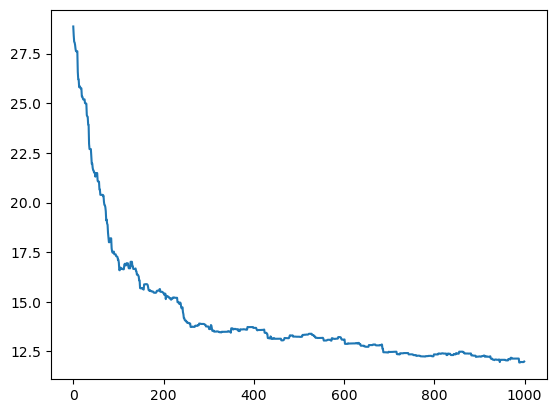

In [32]:
# Check the losses

sns.lineplot(x=list(range(len(nn.L_test))), y=nn.L_test)

In [33]:
from collections import Counter

total = X_test_scale.shape[0]
correct = 0
y_preds = []

for i in range(total):
    y_true = y_test[i]
    y_pred = np.round(nn.forward(X_test_scale[i]))
    y_preds.append(y_pred)
    correct += 1 if y_true == y_pred else 0

accuracy = correct / total
print("Accuracy: {}".format(accuracy))

Counter(y_test)

# Imported method from scikit
# Rows are the actual labels. Cols are the predicted labels.
# Diagonal values are the correct predictions
# Off diagonal counts in rows: where the true class is being misrouted
# Off diagonal counts in cols: which true classes are mistakenly flowing into the predicted class (i.e. false positives)
confusion_matrix(y_true = y_test, y_pred = y_preds)

Accuracy: 0.7704918032786885


array([[23,  7],
       [ 7, 24]])